In [1]:

from astropy.io import fits
import matplotlib.pyplot as plt

def tweedies(data, dist, plot_grad=False):
    covariance = np.cov(data.numpy().T)
    theta_hat = None
    with tf.GradientTape() as tape:
        tape.watch(data)
        prob = dist.prob(data)
        gradients = tape.gradient(prob, data)

        gradients = gradients.numpy()
        prob = prob.numpy()
    prob_div = prob.reshape((len(gradients), 1))
    tweedies = data.numpy() + (covariance @ (gradients / prob_div).T).T
    if type(theta_hat) == np.ndarray:
        theta_hat = np.vstack((theta_hat, tweedies))
    else:
        theta_hat = tweedies
    return theta_hat

In [2]:
apogee14 = fits.open('apogee-rc-DR14.fits')

In [3]:
apogee14.info()

Filename: apogee-rc-DR14.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1                1 BinTableHDU    385   29502R x 187C   [45A, 46A, 18A, 8A, I, 16A, E, E, E, E, E, E, D, D, D, D, J, J, J, 140A, 14A, 3J, J, J, I, E, J, 165A, J, 74A, E, E, E, E, E, E, E, E, J, J, J, E, E, E, I, E, E, E, E, 9E, 9E, 81E, 81E, E, E, E, E, E, E, E, E, E, E, E, E, 5A, J, 183A, 9J, 26E, 26E, 26E, 26E, 26E, 26E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, 26E, 26J, E, 17A, 845A, 804A, 50J, 50J, 207E, 23E, D, D, D, D, D, J, D, D, D, D, D, D, D, D, D, J, D, D, D, D, D, D, D, J, D, D, D]   


In [4]:
#To find relevant data indices for si_fe and mg_fe
#apogee14[1].header

In [5]:
data = apogee14[1].data
mg_fe = [x[80] for x in data]
si_fe = [x[82] for x in data]

In [6]:
# Removes -9999.0
flag = True
while flag:
    try:
        idx = si_fe.index(-9999.0)
        del si_fe[idx]
        del mg_fe[idx]
    except ValueError:
        print('Done')
        flag = False

Done


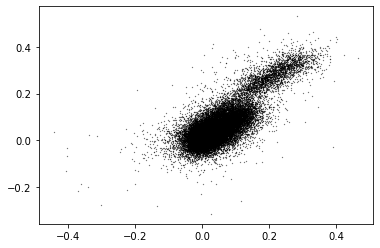

In [7]:
plt.scatter(si_fe, mg_fe, s=0.05, color='black')
plt.show()

In [8]:
import numpy as np
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import os
import sys

from normalizingflows.flow_catalog import PlanarFlow, Made
from data.visu_density import plot_heatmap_2d
from data.toy_data import generate_2d_data
from data.plot_samples import plot_samples_2d
from utils.train_utils import shuffle_split, sanity_check, train_density_estimation

tfd = tfp.distributions
tfb = tfp.bijectors
#tf.random.set_seed(1234)

si_fe = np.array(si_fe)
mg_fe = np.array(mg_fe)
data = np.hstack((si_fe.reshape(-1,1), mg_fe.reshape(-1,1)))

#tf.config.run_functions_eagerly(True) #note runs slow, gets rid of tf.Variable error trying to run training after previous train

tensorflow:  2.0.0
tensorflow-probability:  0.8.0-rc0


In [9]:
batch_size = 800
train_data = tf.data.Dataset.from_tensor_slices(data)
batched_train_data = train_data.batch(batch_size)

2022-03-27 15:17:14.410905: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-27 15:17:14.412165: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


## Planar Flows

In [10]:
# assign a normal distribution
def planar_flow(layers, batched_train_data, base_lr = 1e-3, end_lr = 1e-4,  max_epochs = 500):
    base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], tf.float32))
    # create a flow
    bijectors = []

    for i in range(0, layers):
        bijectors.append(PlanarFlow(input_dimensions=2, case="density_estimation"))

    bijector = tfb.Chain(bijectors=list(reversed(bijectors)), name='chain_of_planar')

    x_dist = tfd.TransformedDistribution(
        distribution=base_dist,
        bijector=bijector
    )

    for bijector in x_dist.bijector.bijectors:
        bijector._u()
    print('trainable params: ' + str(len(x_dist.trainable_variables)))

    # Optimization parameters
    learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(base_lr, max_epochs, end_lr, power=0.5)
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)  # optimizer

    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)  # optimizer

    # Training
    global_step = []
    train_losses = []
    min_train_loss = tf.convert_to_tensor(np.inf, dtype=tf.float32)

    t_start = time.time()  # start time

    # start training
    for i in range(max_epochs):
        for batch in batched_train_data:
            train_loss = train_density_estimation(x_dist, opt, batch)

        # ensure that w.T * u > -1 (invertibility)
        for bijector in x_dist.bijector.bijectors:
            bijector._u()

        if i % int(100) == 0:
            global_step.append(i)
            train_losses.append(train_loss)
            print(f"{i}, train_loss: {train_loss}")
            #plot heatmap
            plot_heatmap_2d(x_dist, -0.4, 0.4, -0.4, 0.4)

    train_time = time.time() - t_start
    print('train_time: ' + str(train_time))
    print('loss: ' + str(train_losses[len(train_losses)-1]))
    print('min_train_loss: ' + str(min_train_loss))
    return x_dist

In [ ]:
dist = planar_flow(6, batched_train_data, max_epochs=1000)

2022-03-27 14:41:54.849383: W tensorflow/python/util/util.cc:299] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


trainable params: 18
0, train_loss: 3.2122251987457275
100, train_loss: -2.7118070125579834


### Calculating gradient of trained distribution for tweedie formula
$$\hat\theta_i = X_i + \Sigma_i\frac{\nabla f_{\hat G_n, \Sigma_i}(X_i)}{f_{\hat G_n, \Sigma_i}(X_i)}$$

### Tweedies:

In [10]:
data = tf.convert_to_tensor(data)

In [11]:
theta_hat = tweedies(data, dist)

NameError: name 'dist' is not defined

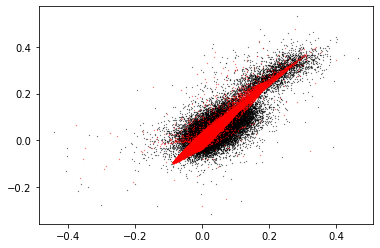

In [17]:
plt.scatter(si_fe, mg_fe, s=0.05, color='black')
plt.scatter(theta_hat[:, 0], theta_hat[:, 1], s=0.05 , color='red')
plt.show()

## Masked Autoregressive Flow

In [10]:
def maf_flow(layers, hidden_shape, batched_train_data, base_lr = 1e-3, end_lr = 1e-4,  max_epochs = 500, plot_freq=100):
    base_dist = tfd.Normal(loc=0.0, scale=1.0)  # specify base distribution

    bijectors = []
    for i in range(0, layers):
        bijectors.append(tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn = Made(params=2, hidden_units=hidden_shape, activation="relu")))
        bijectors.append(tfb.Permute(permutation=[1, 0]))  # data permutation after layers of MAF

    bijector = tfb.Chain(bijectors=list(reversed(bijectors)), name='chain_of_maf')

    maf = tfd.TransformedDistribution(
        distribution=base_dist,
        bijector=bijector,
        event_shape=[2]
    )

    # Optimization parameters
    learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(base_lr, max_epochs, end_lr, power=0.5)
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)  # optimizer

    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)  # optimizer

    # Training
    global_step = []
    train_losses = []
    min_train_loss = tf.convert_to_tensor(np.inf, dtype=tf.float32)

    t_start = time.time()  # start time

    # start training
    for i in range(max_epochs):
        for batch in batched_train_data:
            train_loss = train_density_estimation(maf, opt, batch)

        if i % int(plot_freq) == 0:
            global_step.append(i)
            train_losses.append(train_loss)
            print(f"{i}, train_loss: {train_loss}")
            #plot heatmap
            plot_heatmap_2d(maf, -0.4, 0.4, -0.4, 0.4)

    train_time = time.time() - t_start
    print('train_time: ' + str(train_time))
    print('loss: ' + str(train_losses[len(train_losses)-1]))
    print('min_train_loss: ' + str(min_train_loss))
    return maf


2022-03-27 15:17:15.520474: W tensorflow/python/util/util.cc:299] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


0, train_loss: 0.19283153116703033
500, train_loss: -3.125786066055298
train_time: 1067.1424300670624
loss: tf.Tensor(-3.125786, shape=(), dtype=float32)
min_train_loss: tf.Tensor(inf, shape=(), dtype=float32)


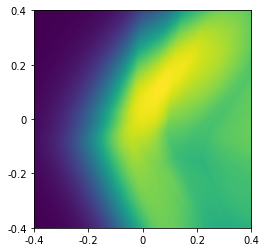

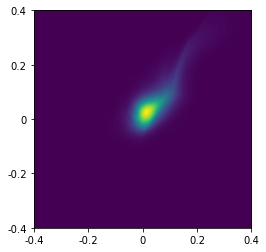

In [11]:
dist = maf_flow(10, [5,5], batched_train_data, max_epochs=1000,plot_freq=500)

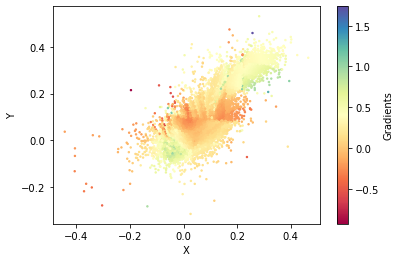

In [17]:
data = tf.convert_to_tensor(data)
theta_hat = tweedies(data, dist)
gradients = theta_hat[:,0] + theta_hat[:, 1]
plt.scatter(data[:,0],data[:,1], c=gradients, s=2, cmap='Spectral')
cbar = plt.colorbar()
cbar.set_label('Gradients')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

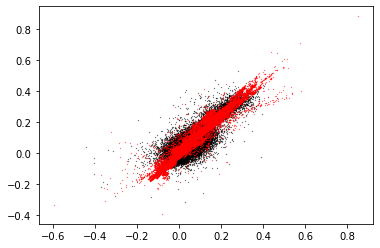

In [13]:
plt.scatter(si_fe, mg_fe, s=0.05, color='black')
plt.scatter(theta_hat[:, 0], theta_hat[:, 1], s=0.05 , color='red')
plt.show()